In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn.functional as F
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import shap
from torch.nn import init

/home/bettimj/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/bettimj/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

In [5]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
#Open the expression data as a pandas data frame
exp_path = "/home/bettimj/gamazon_rotation/deep_learning_tcga_lc/data/all_common_samples_exp_scc_ad_combined_no_na_protein_coding.txt"

exp_file = pd.read_csv(exp_path, sep = "\t")
exp_file = exp_file.sample(frac=1)
exp_file

,sample,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,AC037459.4,SMIM42,DUS4L-BCAP29,C8orf44-SGK3,ELOA3B,NPBWR1,ELOA3D,PDCD6-AHRR,ELOA3,hist
590,TCGA-69-7978-01A,-0.088642,-0.066272,0.423086,-0.286537,-0.141132,0.829180,0.422346,0.049573,0.990147,...,-0.232533,-0.212406,0.623776,-0.458333,-0.106626,-0.344866,-0.138918,-0.314281,-0.095260,ad
278,TCGA-49-AARN-01A,-0.649074,-0.074702,-0.778253,-0.526028,-0.638816,-0.692420,-0.597214,-1.014995,-0.357579,...,-0.558432,-0.212406,-1.079483,-0.458333,-0.106626,-0.336479,-0.138918,-0.314281,-0.095260,ad
14,TCGA-05-4410-01A,-0.729019,-0.069082,-1.224584,-0.461081,-0.699935,-0.483254,-0.465163,-0.836213,-0.100797,...,-0.493252,-0.212406,1.151236,-0.458333,-0.106626,-0.328092,-0.138918,1.713930,-0.095260,ad
678,TCGA-78-7154-01A,0.294360,-0.074702,1.992544,-0.410342,0.245955,-0.668069,-0.146407,0.395886,0.726482,...,0.093366,-0.212406,-1.106955,-0.458333,-0.106626,-0.151956,-0.138918,-0.314281,-0.095260,ad
338,TCGA-55-6970-01A,0.267440,-0.074702,0.379287,1.164616,1.279158,-0.176062,0.541879,0.980993,2.348840,...,-0.753971,-0.212406,-0.392685,-0.458333,-0.106626,-0.344866,-0.138918,1.713930,-0.095260,ad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,TCGA-95-7944-01A,-0.735953,-0.074702,1.051912,-0.250005,0.635953,-0.028086,0.634085,1.786139,-0.456979,...,-0.232533,-0.212406,1.151236,-0.458333,-0.106626,-0.353254,-0.138918,-0.314281,-0.095260,ad
192,TCGA-43-8116-01A,-0.451605,-0.069396,-0.529177,-0.058593,-0.150182,-0.580266,-0.595170,-0.817938,-0.658452,...,-0.200589,-0.194318,0.166221,-0.675885,-0.099807,-0.360702,-0.135834,-0.319654,-0.042601,scc
629,TCGA-77-7138-01A,0.606178,-0.165468,1.891903,-0.083381,0.189915,-0.589502,-0.626840,-0.337302,-0.645960,...,-0.791631,-0.194318,-0.417284,-0.675885,-0.099807,-0.275396,-0.135834,-0.319654,-0.042601,scc
559,TCGA-66-2787-01A,-0.159431,-0.069396,0.692379,-0.524615,0.332281,-0.187480,-0.178223,-0.842507,3.559014,...,-0.200589,-0.194318,-0.268015,-0.675885,-0.099807,-0.341016,-0.135834,-0.319654,-0.042601,scc


In [7]:
#Prepare training, validation, and test data

train = exp_file.iloc[:,1:]
train_features = train.copy()
train_labels = train_features.pop('hist')
train_labels

train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [8]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([769])

In [9]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([96])

In [10]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([97, 18991])

In [11]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [12]:
torch.cuda.is_available()

True

In [13]:
#Optimizng the number of neurons in each hidden layer - starting network has one hidden layer
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=60,
    module__num_hidden_layers=1,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__hidden_size': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.831372 using {'module__hidden_size': 40}
0.796083 (0.035977) with: {'module__hidden_size': 10}
0.791575 (0.043484) with: {'module__hidden_size': 20}
0.829250 (0.055114) with: {'module__hidden_size': 30}
0.831372 (0.014508) with: {'module__hidden_size': 40}
0.748847 (0.065928) with: {'module__hidden_size': 50}
0.766657 (0.068941) with: {'module__hidden_size': 60}
0.654207 (0.126753) with: {'module__hidden_size': 70}
0.667389 (0.054698) with: {'module__hidden_size': 80}
0.687998 (0.040766) with: {'module__hidden_size': 90}
0.607650 (0.056075) with: {'module__hidden_size': 100}


In [14]:
#Optimizng the number hidden layers - starting network has one hidden layer, so the actual number of hidden layers in grid search models is module__num_hidden_layers + 1
n_cols = train_set_final.shape[1]
input_shape = n_cols
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=1,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__num_hidden_layers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.918142 using {'module__num_hidden_layers': 3}
0.774855 (0.085242) with: {'module__num_hidden_layers': 1}
0.909434 (0.034999) with: {'module__num_hidden_layers': 2}
0.918142 (0.021083) with: {'module__num_hidden_layers': 3}
0.897859 (0.025266) with: {'module__num_hidden_layers': 4}
0.902424 (0.022108) with: {'module__num_hidden_layers': 5}
0.900110 (0.012056) with: {'module__num_hidden_layers': 6}
0.880802 (0.043258) with: {'module__num_hidden_layers': 7}
0.807957 (0.135170) with: {'module__num_hidden_layers': 8}
0.740157 (0.155403) with: {'module__num_hidden_layers': 9}
0.802779 (0.140559) with: {'module__num_hidden_layers': 10}


In [16]:
#Optimizng the batch size and number of epochs
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=50,
    batch_size=40,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'batch_size':[10, 20, 40, 60, 80, 100],
    'max_epochs': [10, 20, 30, 40, 50],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best: 0.926408 using {'batch_size': 20, 'max_epochs': 40}
0.735627 (0.105642) with: {'batch_size': 10, 'max_epochs': 10}
0.633693 (0.039948) with: {'batch_size': 10, 'max_epochs': 20}
0.573740 (0.035147) with: {'batch_size': 10, 'max_epochs': 30}
0.540416 (0.023103) with: {'batch_size': 10, 'max_epochs': 40}
0.641561 (0.148458) with: {'batch_size': 10, 'max_epochs': 50}
0.894918 (0.023002) with: {'batch_size': 20, 'max_epochs': 10}
0.911071 (0.024880) with: {'batch_size': 20, 'max_epochs': 20}
0.906813 (0.020519) with: {'batch_size': 20, 'max_epochs': 30}
0.926408 (0.026375) with: {'batch_size': 20, 'max_epochs': 40}
0.904249 (0.055868) with: {'batch_size': 20, 'max_epochs': 50}
0.876782 (0.027578) with: {'batch_size': 40, 'max_epochs': 10}
0.915772 (0.017080) with: {'batch_size': 40, 'max_epochs': 20}
0.908149 (0.007200) with: {'batch_size': 40, 'max_epochs': 30}
0.901381 (0.025939) with: {'batch_size': 40, 'max_epochs': 40

In [17]:
#Optimizng the training optimization algorithm
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.Adam,
    max_epochs=40,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'optimizer':[optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                  optim.Adam, optim.Adamax, optim.NAdam]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.952826 using {'optimizer': <class 'torch.optim.nadam.NAdam'>}
0.866119 (0.025425) with: {'optimizer': <class 'torch.optim.sgd.SGD'>}
0.500000 (0.000000) with: {'optimizer': <class 'torch.optim.rmsprop.RMSprop'>}
0.944899 (0.013514) with: {'optimizer': <class 'torch.optim.adagrad.Adagrad'>}
0.882045 (0.007710) with: {'optimizer': <class 'torch.optim.adadelta.Adadelta'>}
0.916719 (0.028763) with: {'optimizer': <class 'torch.optim.adam.Adam'>}
0.930498 (0.008389) with: {'optimizer': <class 'torch.optim.adamax.Adamax'>}
0.952826 (0.004935) with: {'optimizer': <class 'torch.optim.nadam.NAdam'>}


In [18]:
#Optimizng the learning rate and momentum
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.NAdam,
    max_epochs=40,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'optimizer__lr': [0.0001, 0.0005 ,0.001, 0.005, 0.01, 0.1, 0.2, 0.3],
    #'optimizer__momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best: 0.943632 using {'optimizer__lr': 0.001}
0.920044 (0.016287) with: {'optimizer__lr': 0.0001}
0.941037 (0.017088) with: {'optimizer__lr': 0.0005}
0.943632 (0.007815) with: {'optimizer__lr': 0.001}
0.942958 (0.012907) with: {'optimizer__lr': 0.005}
0.929085 (0.009094) with: {'optimizer__lr': 0.01}
0.500000 (0.000000) with: {'optimizer__lr': 0.1}
0.500000 (0.000000) with: {'optimizer__lr': 0.2}
0.500000 (0.000000) with: {'optimizer__lr': 0.3}


In [19]:
#Optimizng how the weights are initialized
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.relu(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.NAdam,
    max_epochs=40,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.001,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__weight_init_hidden': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_],
    'module__weight_init_out': [init.uniform_, init.normal_, init.zeros_,
                           init.xavier_normal_, init.xavier_uniform_,
                           init.kaiming_normal_, init.kaiming_uniform_]
}

# # Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best: 0.940281 using {'module__weight_init_hidden': <function xavier_uniform_ at 0x2b3a68cc5870>, 'module__weight_init_out': <function zeros_ at 0x2b3a68cc5630>}
0.514270 (0.019996) with: {'module__weight_init_hidden': <function uniform_ at 0x2b3a68cc52d0>, 'module__weight_init_out': <function uniform_ at 0x2b3a68cc52d0>}
0.499639 (0.037024) with: {'module__weight_init_hidden': <function uniform_ at 0x2b3a68cc52d0>, 'module__weight_init_out': <function normal_ at 0x2b3a68cc5360>}
0.504464 (0.037583) with: {'module__weight_init_hidden': <function uniform_ at 0x2b3a68cc52d0>, 'module__weight_init_out': <function zeros_ at 0x2b3a68cc5630>}
0.495472 (0.041883) with: {'module__weight_init_hidden': <function uniform_ at 0x2b3a68cc52d0>, 'module__weight_init_out': <function xavier_normal_ at 0x2b3a68cc5900>}
0.504123 (0.040099) with: {'module__weight_init_hidden': <function uniform_ at 0x2b3a68cc52d0>, 'module__weight_init_out': <f

In [20]:
#Optimizng the activation function
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)
    def forward(self, x):
        x = self.activation(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.NAdam,
    max_epochs=40,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.001,
    module__weight_init_hidden = init.xavier_uniform_,
    module__weight_init_out = init.zeros_,
    verbose=False,
    device = "cuda"
)

# Define the grid of model parameters to search over
param_grid = {
    'module__activation': [nn.Identity, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.ReLU6,
                          nn.GELU, nn.Softplus, nn.Softsign, nn.Tanh,
                          nn.Sigmoid, nn.Hardsigmoid]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best: 0.941436 using {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
0.242282 (0.028350) with: {'module__activation': <class 'torch.nn.modules.linear.Identity'>}
0.940202 (0.012608) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>}
0.932654 (0.014214) with: {'module__activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
0.941436 (0.014858) with: {'module__activation': <class 'torch.nn.modules.activation.ELU'>}
0.910016 (0.023277) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU6'>}
0.931568 (0.011884) with: {'module__activation': <class 'torch.nn.modules.activation.GELU'>}
0.931435 (0.018762) with: {'module__activation': <class 'torch.nn.modules.activation.Softplus'>}
0.541367 (0.040123) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>}
0.614365 (0.033409) with: {'module__activation': <class 'torch.nn.modules.activation.Tanh'>}
0.

In [21]:
#Optimizng dropout
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, dropout_rate3, weight_constraint):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        self.weight_constraint = weight_constraint
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_out(self.fc4.weight)
    def forward(self, x):
        # maxnorm weight before actual forward pass
        with torch.no_grad():
            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc1.weight *= (desired / norm)

            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc2.weight *= (desired / norm)

            norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc3.weight *= (desired / norm)

        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x.squeeze()
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.NAdam,
    max_epochs=40,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.001,
    module__weight_init_hidden = init.xavier_uniform_,
    module__weight_init_out = init.zeros_,
    module__activation = nn.ELU,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__dropout_rate1': [0.0, 0.1, 0.3, 0.5],
    'module__dropout_rate2': [0.0, 0.1, 0.3, 0.5],
    'module__dropout_rate3': [0.0, 0.1, 0.3, 0.5],
    'module__weight_constraint': [1.0, 3.0, 5.0, 7.0, 9.0]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best: 0.951987 using {'module__dropout_rate1': 0.1, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 3.0}
0.926825 (0.013204) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 1.0}
0.938490 (0.007324) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 3.0}
0.939003 (0.013602) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 5.0}
0.941436 (0.014858) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 7.0}
0.944426 (0.009420) with: {'module__dropout_rate1': 0.0, 'module__dropout_rate2': 0.0, 'module__dropout_rate3': 0.0, 'module__weight_constraint': 9.0}
0.925595 (0.014529) with: {'module_

In [23]:
#Optimizng L1 and L2 regularization
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
n_cols = train_set_final.shape[1]
input_shape = n_cols

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate1, dropout_rate2, dropout_rate3, weight_constraint, alpha_l1, alpha_l2):
        super(Net, self).__init__()
        self.alpha_l1 = alpha_l1
        self.alpha_l2 = alpha_l2
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.activation = activation()
        self.weight_constraint = weight_constraint
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_out(self.fc4.weight)
    def forward(self, x):
        # maxnorm weight before actual forward pass
        with torch.no_grad():
            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc1.weight *= (desired / norm)

            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc2.weight *= (desired / norm)

            norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc3.weight *= (desired / norm)

        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x.squeeze()
    
# Add regularization to the optimizer
from skorch.utils import to_device
from skorch.callbacks import Callback
from skorch.history import History

class RegularizationCallback(Callback):
    def __init__(self, alpha_l1=0.01, alpha_l2=0.01, seed_value=0):
        self.alpha_l1 = alpha_l1
        self.alpha_l2 = alpha_l2
        #self.seed_value = seed_value

    def on_train_begin(self, net, X, y):
        #torch.manual_seed(self.seed_value)
        self.optimizer = net.optimizer_

    def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
        # Apply L1 regularization
        for param in net.module_.parameters():
            if param.requires_grad:
                param.data = to_device(param.data, device=net.device)
                param.data = param.data - self.alpha_l1 * torch.sign(param.data)

        # Apply L2 regularization
        for param in net.module_.parameters():
            if param.requires_grad:
                param.data = to_device(param.data, device=net.device)
                param.data = param.data - self.alpha_l2 * param.data

        # Update optimizer state with new parameter values
        self.optimizer.state = net.optimizer_.state

        # Add regularization loss to history
        history = net.history
        if 'reg_loss' not in history:
            history.new_epoch()
        history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
                              self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
model = NeuralNetClassifier(
    Net,
    criterion=BCELoss,
    optimizer=optim.NAdam,
    max_epochs=40,
    batch_size=20,
    module__input_size=input_shape,
    module__hidden_size=40,
    module__num_hidden_layers=3,
    module__output_size=1,
    optimizer__lr = 0.001,
    module__weight_init_hidden = init.xavier_uniform_,
    module__weight_init_out = init.zeros_,
    module__activation = nn.ELU,
    module__dropout_rate1 = 0.1,
    module__dropout_rate2=0.0,
    module__dropout_rate3=0.0,
    module__weight_constraint = 3.0,
    verbose=False,
    device = "cuda",
    callbacks=[
        EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
        EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
        RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
    ]
)

# Define the grid of model parameters to search over
param_grid = {
    'module__alpha_l1': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'module__alpha_l2': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

# Create a GridSearchCV object and fit it to the training data
split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
X = torch.cat((train_set_final, val_set_final), axis=0)
y = torch.cat((train_labels_final, val_labels_final), axis=0)
pds = PredefinedSplit(test_fold = split_index)

clf = GridSearchCV(estimator=model,
                   cv=KFold(5, random_state=0, shuffle=True),
                   param_grid=param_grid,
                   scoring = "roc_auc",
                   n_jobs=1,
                   verbose=1)

# Fit with all data
grid_result = clf.fit(X, y.float())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best: 0.962293 using {'module__alpha_l1': 0.1, 'module__alpha_l2': 0.05}
0.950728 (0.024850) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0}
0.949992 (0.019965) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.001}
0.946091 (0.016206) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.005}
0.932880 (0.020213) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.01}
0.940154 (0.015583) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.05}
0.957643 (0.010623) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.1}
0.950389 (0.019579) with: {'module__alpha_l1': 0, 'module__alpha_l2': 0.5}
0.943109 (0.016043) with: {'module__alpha_l1': 0, 'module__alpha_l2': 1}
0.943705 (0.025627) with: {'module__alpha_l1': 0.001, 'module__alpha_l2': 0}
0.948572 (0.015439) with: {'module__alpha_l1': 0.001, 'module__alpha_l2': 0.001}
0.949090 (0.028791) with: {'module__alpha_l1': 0.001, 'module__alpha_l2': 0.005}
0.944795 (0.014941) with

Text(0.5, 1.0, 'Training and Validation AUC')

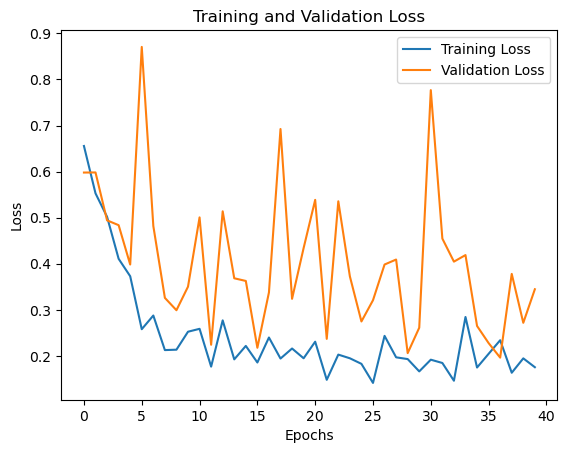

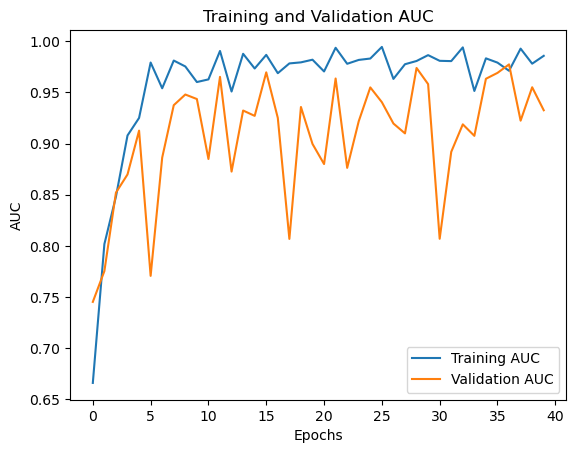

In [24]:
import matplotlib.pyplot as plt

# get the best estimator
best_estimator = grid_result.best_estimator_
#print(best_estimator.history)

# get training and validation loss and AUC
train_loss = best_estimator.history[:, 'train_loss']
val_loss = best_estimator.history[:, 'valid_loss']
train_auc = best_estimator.history[:, 'train_auc']
val_auc = best_estimator.history[:, 'valid_auc']

# plot the training and validation loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# plot the training and validation AUC curves
plt.figure()
plt.plot(train_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')

In [25]:
best_estimator = grid_result.best_estimator_
print(best_estimator)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (fc1): Linear(in_features=18991, out_features=40, bias=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=40, out_features=40, bias=True)
    (dropout2): Dropout(p=0.0, inplace=False)
    (fc3): Linear(in_features=40, out_features=40, bias=True)
    (dropout3): Dropout(p=0.0, inplace=False)
    (fc4): Linear(in_features=40, out_features=1, bias=True)
    (activation): ELU(alpha=1.0)
  ),
)


In [26]:
best_model = grid_result.best_estimator_.module_
# Save the best model to HDF5 format
torch.save(best_model.state_dict(), 'best_protein_coding_gene_expression_model.h5')

In [27]:
# Evaluate performance on test set
y_pred = best_model(test_set_final.to("cuda"))
auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

print(auc)

0.936663693131133


In [28]:
# #Optimizng convolutions
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
# n_cols = train_set_final.shape[1]
# input_shape = n_cols

# class Net(nn.Module):
#     def __init__(self, input_size, conv_num_filters, conv_kernel_size, conv_padding, pool_kernel_size, pool_stride, hidden_size, output_size, num_hidden_layers, weight_init_hidden, weight_init_out, activation, dropout_rate, weight_constraint, alpha_l1, alpha_l2, batch_size=20):
#         super(Net, self).__init__()
        
#         self.batch_size = batch_size
#         self.conv_num_filters = conv_num_filters
#         self.conv_kernel_size = conv_kernel_size
#         self.conv_padding = conv_padding
#         self.batch_size = batch_size
#         self.pool_kernel_size = pool_kernel_size
#         self.pool_stride = pool_stride

#         # Define the convolutional and max pooling layers
#         conv_layers = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=conv_padding),
#             nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
#         )
        
#         # Generate some random input
#         z = torch.randn(1, input_shape)
        
#         # Pass the input through the convolutional layers
#         conv_out = conv_layers(z)

#         # Calculate the number of features in the output of the last convolutional layer
#         fc1_in_size = torch.flatten(conv_out, start_dim = 0, end_dim = 1).shape[0]
#         self.fc1_in_size = fc1_in_size
#         #print("fc1 in size:")
#         print(fc1_in_size)
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=self.conv_num_filters, kernel_size=self.conv_kernel_size, padding=self.conv_padding)
#         self.pool1 = nn.MaxPool1d(kernel_size=(pool_kernel_size), stride=(pool_stride))
        
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2
#         self.fc1 = nn.Linear(self.fc1_in_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.dropout3 = nn.Dropout(dropout_rate)
#         self.fc4 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         # manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_hidden(self.fc3.weight)
#         weight_init_out(self.fc4.weight)
    
#     def forward(self, x):
#         batch_size = x.shape[0]
#         # maxnorm weight before actual forward pass
#         with torch.no_grad():
#             norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc1.weight *= (desired / norm)

#             norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc2.weight *= (desired / norm)

#             norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc3.weight *= (desired / norm)

#         out = []
#         for i in range(batch_size):
#             x_batch = x[i].unsqueeze(0)
#             x_batch = self.activation(self.conv1(x_batch))
#             x_batch = self.pool1(x_batch)
#             x_batch = torch.flatten(x_batch, start_dim = 0, end_dim = 1)
#             #print("x_batch shape:")
#             #print(x_batch.shape)
#             x_batch = self.activation(self.fc1(x_batch))
#             x_batch = self.dropout1(x_batch)
#             x_batch = self.activation(self.fc2(x_batch))
#             x_batch = self.dropout2(x_batch)
#             x_batch = self.activation(self.fc3(x_batch))
#             x_batch = self.dropout3(x_batch)
#             x_batch = torch.sigmoid(self.fc4(x_batch))
#             out.append(x_batch.squeeze())
#         return torch.stack(out, dim=0)
    
# # Add regularization to the optimizer
# from skorch.utils import to_device
# from skorch.callbacks import Callback
# from skorch.history import History

# class RegularizationCallback(Callback):
#     def __init__(self, alpha_l1=0.01, alpha_l2=0.01):
#         self.alpha_l1 = alpha_l1
#         self.alpha_l2 = alpha_l2

#     def on_train_begin(self, net, X, y):
#         self.optimizer = net.optimizer_

#     def on_epoch_end(self, net, dataset_train, dataset_valid=None, **kwargs):
#         # Apply L1 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l1 * torch.sign(param.data)

#         # Apply L2 regularization
#         for param in net.module_.parameters():
#             if param.requires_grad:
#                 param.data = to_device(param.data, device=net.device)
#                 param.data = param.data - self.alpha_l2 * param.data

#         # Update optimizer state with new parameter values
#         self.optimizer.state = net.optimizer_.state

#         # Add regularization loss to history
#         history = net.history
#         if 'reg_loss' not in history:
#             history.new_epoch()
#         history.record('reg_loss', self.alpha_l1 * sum([torch.norm(param, p=1) for param in net.module_.parameters() if param.requires_grad]) + 
#                               self.alpha_l2 * sum([torch.norm(param, p=2) for param in net.module_.parameters() if param.requires_grad]))
    
# model = NeuralNetClassifier(
#     Net,
#     criterion=BCELoss,
#     optimizer=optim.Adagrad,
#     max_epochs=20,
#     batch_size=20,
#     module__input_size=input_shape,
#     module__hidden_size=10,
#     module__num_hidden_layers=4,
#     module__output_size=1,
#     optimizer__lr = 0.01,
#     module__weight_init_hidden = init.xavier_uniform_,
#     module__weight_init_out = init.zeros_,
#     module__activation = nn.GELU,
#     module__dropout_rate = 0.0,
#     module__weight_constraint = 8.0,
#     module__alpha_l1 = 0,
#     module__alpha_l2 = 0.001,
#     verbose=True,
#     device = "cuda",
#     callbacks=[
#         EpochScoring(scoring='roc_auc', name='train_auc', on_train=True),
#         EpochScoring(scoring='roc_auc', name='valid_auc', on_train=False),
#         RegularizationCallback(alpha_l1 = 0.01, alpha_l2 = 0.01)
#     ]
# )

# # Define the grid of model parameters to search over
# param_grid = {
#     'module__conv_num_filters': [8, 16, 32, 64],
#     'module__conv_kernel_size': [3, 5, 7],
#     'module__conv_padding': [0, 1, 2],
#     'module__pool_kernel_size': [2, 3, 4],
#     'module__pool_stride': [1, 2, 3] 
# }

# # Create a GridSearchCV object and fit it to the training data
# split_index = [-1]*len(train_set_final) + [0]*len(val_set_final)
# X = torch.cat((train_set_final, val_set_final), axis=0)
# X.unsqueeze(0)
# y = torch.cat((train_labels_final, val_labels_final), axis=0)
# pds = PredefinedSplit(test_fold = split_index)

# clf = GridSearchCV(estimator=model,
#                    cv=KFold(5, random_state=0, shuffle=True),
#                    param_grid=param_grid,
#                    scoring = "roc_auc",
#                    n_jobs=1,
#                    verbose=1)

# # Fit with all data
# grid_result = clf.fit(X, y.float())

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [29]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
# from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
# import numpy as np
# from torch.utils.data import DataLoader

# num_hidden_layers = 5

# class Net(nn.Module):
#     def __init__(self, input_size=57508, hidden_size=10, output_size=1, num_hidden_layers=4, weight_init_hidden=init.xavier_uniform_, weight_init_out=init.zeros_, activation=nn.GELU, dropout_rate1=0.0, dropout_rate2=0.0, dropout_rate3=0.1, dropout_rate4=0.0, weight_constraint=1.0):
#         super(Net, self).__init__()

#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.dropout1 = nn.Dropout(dropout_rate1)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.dropout2 = nn.Dropout(dropout_rate2)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.dropout3 = nn.Dropout(dropout_rate3)
#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         self.dropout4 = nn.Dropout(dropout_rate4)
#         self.fc5 = nn.Linear(hidden_size, output_size)
#         self.activation = activation()
#         self.weight_constraint = weight_constraint
#         # manually init weights
#         weight_init_hidden(self.fc1.weight)
#         weight_init_hidden(self.fc2.weight)
#         weight_init_hidden(self.fc3.weight)
#         weight_init_hidden(self.fc4.weight)
#         weight_init_out(self.fc5.weight)
#     def forward(self, x):
#         # maxnorm weight before actual forward pass
#         with torch.no_grad():
#             norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc1.weight *= (desired / norm)

#             norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc2.weight *= (desired / norm)

#             norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc3.weight *= (desired / norm)
            
#             norm = self.fc4.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
#             desired = torch.clamp(norm, max=self.weight_constraint)
#             self.fc4.weight *= (desired / norm)

#         x = self.activation(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.activation(self.fc2(x))
#         x = self.dropout2(x)
#         x = self.activation(self.fc3(x))
#         x = self.dropout3(x)
#         x = self.activation(self.fc4(x))
#         x = self.dropout4(x)
#         x = torch.sigmoid(self.fc5(x))
#         return x.squeeze()
    
# model = Net()
# model.load_state_dict(torch.load('best_gene_expression_model.h5'))

# model.eval()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# batch_size = 20

# test_loader = DataLoader(test_set_final, batch_size=batch_size)

# model.to(device)

# ig = IntegratedGradients(model)
# ig_nt = NoiseTunnel(ig)
# dl = DeepLift(model)
# gs = GradientShap(model)
# fa = FeatureAblation(model)

# # Loop over the batches and compute the attributions for each batch
# for batch in test_loader:
#     # Move the batch to the device
#     batch = batch.to(device)

#     # Compute the attributions for this batch using Captum
#     ig_attr_batch = ig.attribute(batch, n_steps=50)
#     #print(ig_attr_batch)
#     ig_nt_attr_batch = ig_nt.attribute(batch)
#     #print(ig_nt_attr_batch)
#     dl_attr_batch = dl.attribute(batch)
#     #print(dl_attr_batch)
#     gs_attr_batch = gs.attribute(batch, X)
#     #print(gs_attr_batch)
#     fa_attr_batch = fa.attribute(batch)
#     #print(fa_attr_batch)

In [31]:
import torch
import shap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.cat((train_set_final, val_set_final), axis=0).to(device)

class Net(nn.Module):
    def __init__(self, input_size=18991, hidden_size=40, output_size=1, num_hidden_layers=3, weight_init_hidden=init.xavier_uniform_, weight_init_out=init.zeros_, activation=torch.nn.functional.elu, dropout_rate1=0.1, dropout_rate2=0.0, dropout_rate3=0.0, weight_constraint=3.0):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate3)
        self.fc4 = nn.Linear(hidden_size, output_size)
        #self.activation = activation()
        self.weight_constraint = weight_constraint
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        weight_init_hidden(self.fc2.weight)
        weight_init_hidden(self.fc3.weight)
        weight_init_out(self.fc4.weight)
    def forward(self, x):
        # maxnorm weight before actual forward pass
        with torch.no_grad():
            norm = self.fc1.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc1.weight *= (desired / norm)

            norm = self.fc2.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc2.weight *= (desired / norm)

            norm = self.fc3.weight.norm(2, dim=0, keepdim=True).clamp(min=self.weight_constraint / 2)
            desired = torch.clamp(norm, max=self.weight_constraint)
            self.fc3.weight *= (desired / norm)

        x = torch.nn.functional.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.nn.functional.gelu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.nn.functional.gelu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc4(x))
        return x.view(-1, 1)
    
model = Net().to(device)
model.load_state_dict(torch.load('best_protein_coding_gene_expression_model.h5'))

explainer = shap.DeepExplainer(model, X)

#shap_values = explainer.shap_values(test_set_final)
#y_pred = model(test_set_final)
#auc = roc_auc_score(test_labels_final, y_pred.detach().cpu().numpy())

#print(auc)

In [32]:
shap_values = explainer.shap_values(test_set_final)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


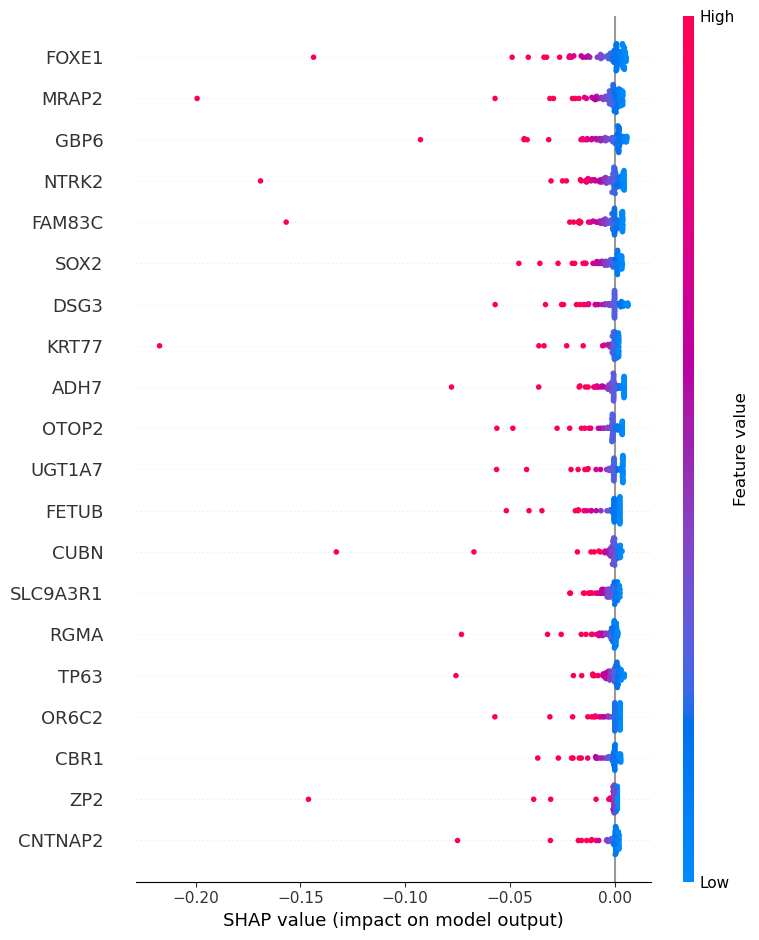

In [33]:
feature_names = exp_file.iloc[:,1:].columns.values.tolist()

shap.summary_plot(shap_values, test_set_final, feature_names = feature_names)

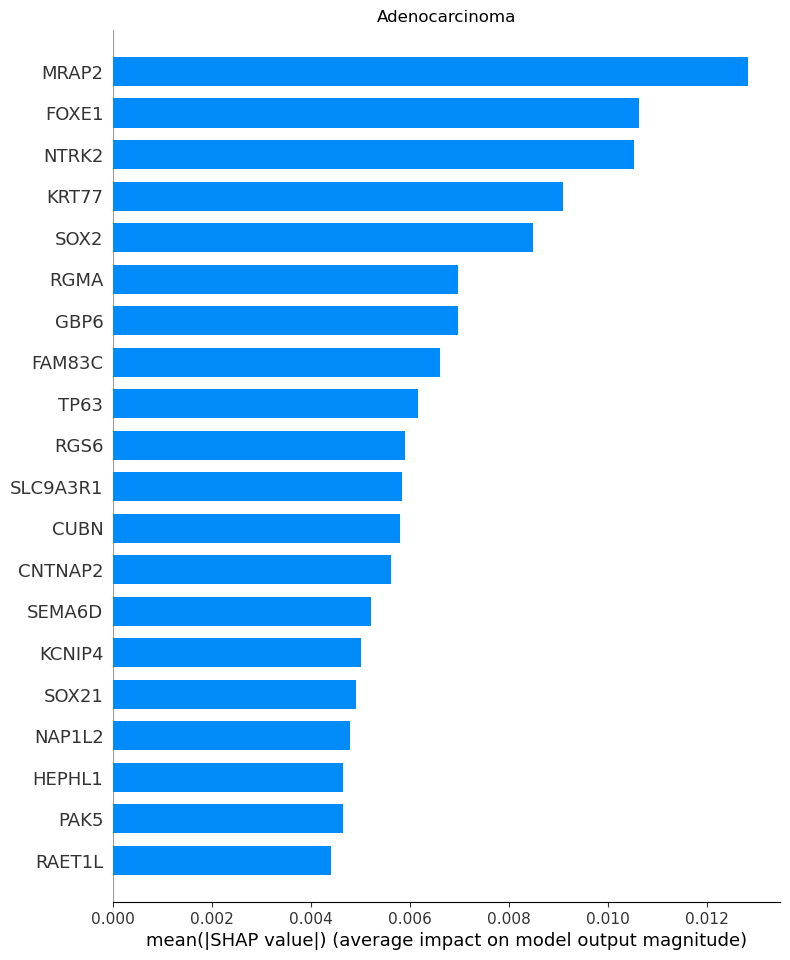

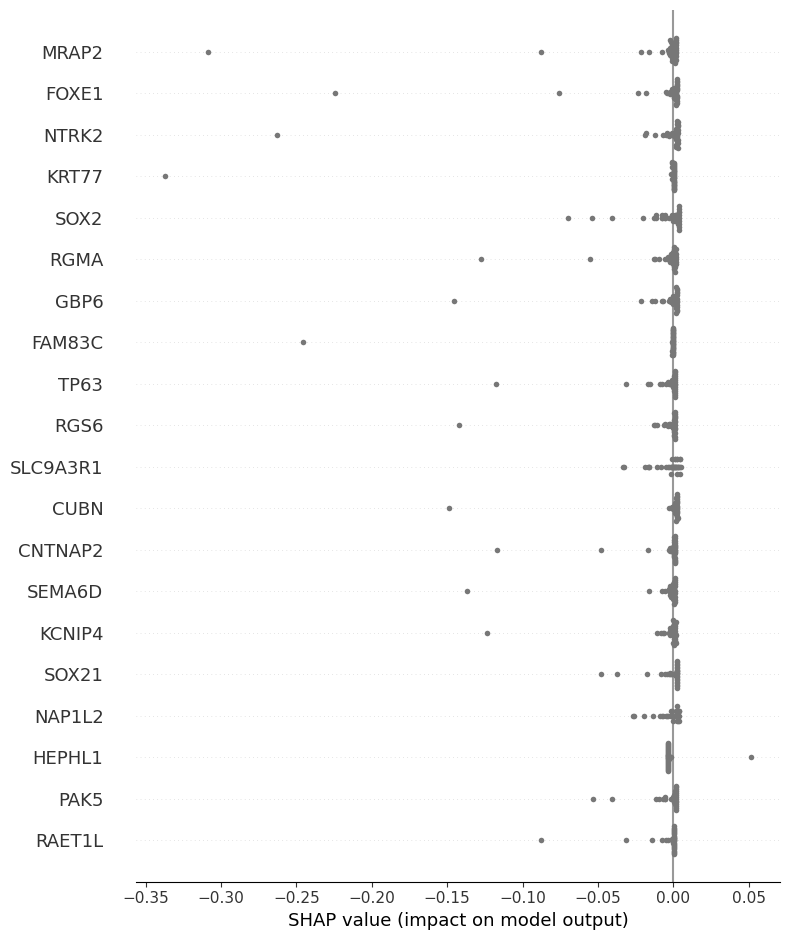

In [34]:
#Adenocarcinoma
# filter instances with label 0
label_0_instances = test_set_final[test_labels_final == 0].to(device)

# create explainer for label 0 instances
explainer_0 = shap.DeepExplainer(model, label_0_instances)

# calculate shap values for label 0 instances
shap_values_0 = explainer_0.shap_values(label_0_instances)

# create shap summary plot for label 0 instances
#shap.summary_plot(shap_values_0, label_0_instances, feature_names=exp_file.columns[1:], plot_type='bar', show=False)

# create first plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values_0, label_0_instances, feature_names=exp_file.columns[1:], plot_type='bar', show=False)
ax.set_title("Adenocarcinoma")

# create second plot
fig2, ax2 = plt.subplots()
shap.summary_plot(shap_values_0, label_0_instances, feature_names=exp_file.columns[1:], color_bar=False)
ax2.set_title("Adenocarcinoma")

# display the two plots side by side
plt.show()

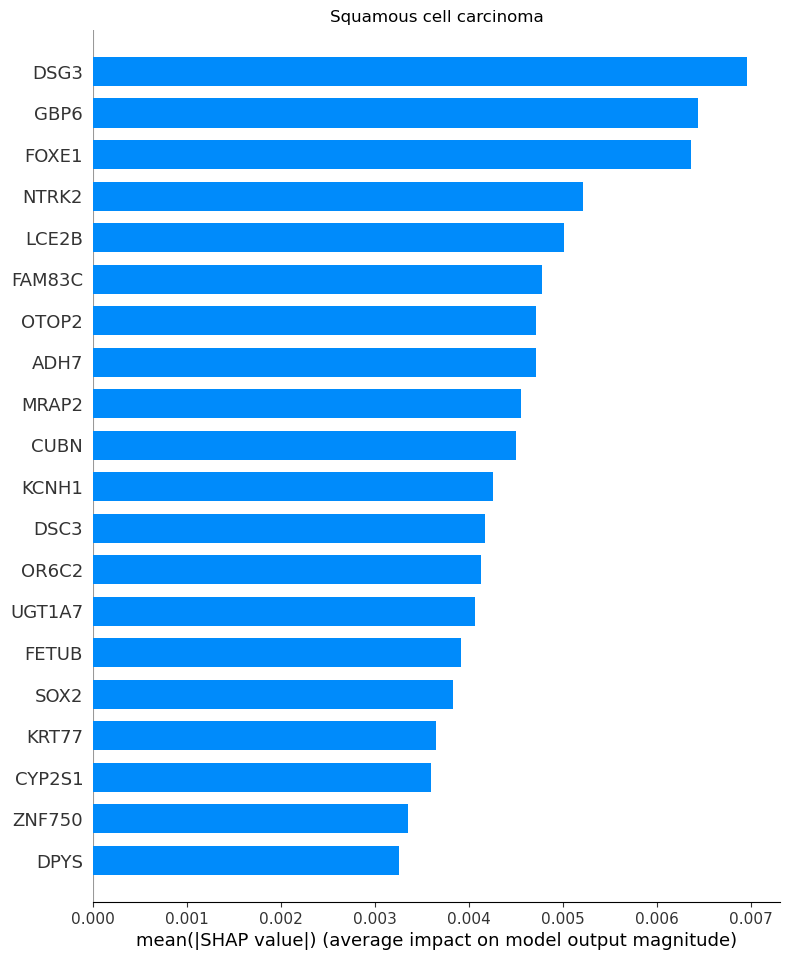

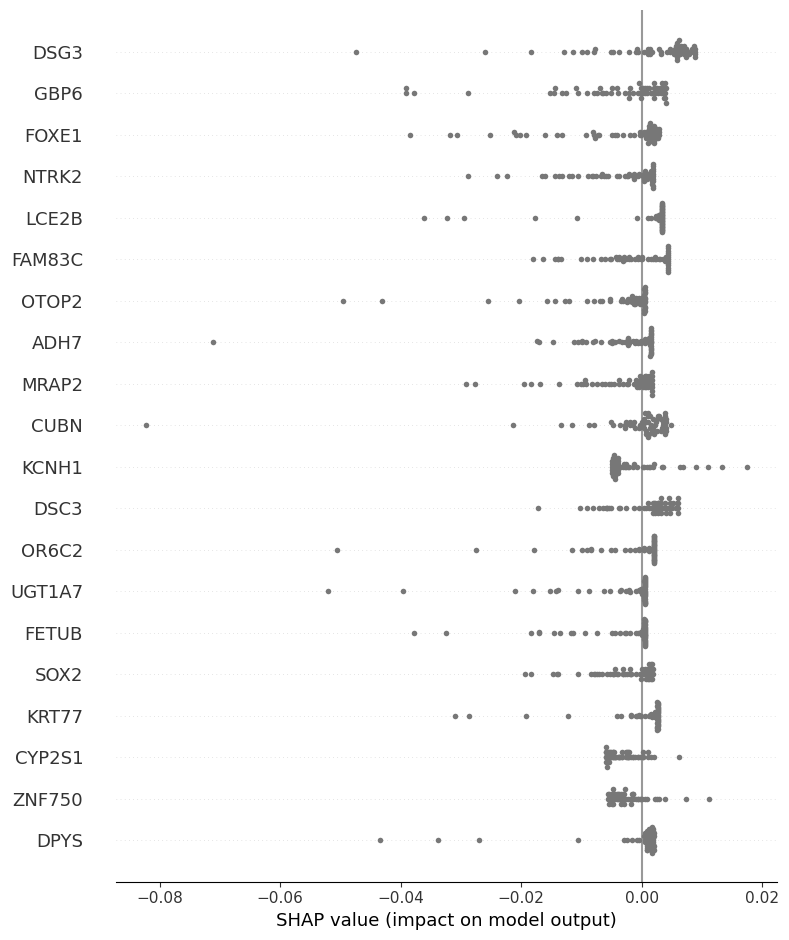

In [35]:
#Squamous cell carcinoma (SCC)
# filter instances with label 1
label_1_instances = test_set_final[test_labels_final == 1].to(device)

# create explainer for label 1 instances
explainer_1 = shap.DeepExplainer(model, label_1_instances)

# calculate shap values for label 0 instances
shap_values_1 = explainer_1.shap_values(label_1_instances)

# create first plot
fig, ax = plt.subplots()
shap.summary_plot(shap_values_1, label_1_instances, feature_names=exp_file.columns[1:], plot_type='bar', show=False)
ax.set_title("Squamous cell carcinoma")

# create second plot
fig2, ax2 = plt.subplots()
shap.summary_plot(shap_values_1, label_1_instances, feature_names=exp_file.columns[1:], color_bar=False)
ax2.set_title("Squamous cell carcinoma")

# display the two plots side by side
plt.show()

In [36]:
import numpy as np

# Compute the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Print the feature importances in descending order
sorted_idx = np.argsort(mean_shap_values)[::-1]
#for i in sorted_idx:
#    print(f"{feature_names[i]}: {mean_shap_values[i]:.3f}")

In [37]:
# filter instances with label 0 (Adenocarcinoma)
label_0_instances = test_set_final[test_labels_final == 0].to(device)

# create explainer for label 0 instances
explainer_0 = shap.DeepExplainer(model, label_0_instances)

# calculate shap values for label 0 instances
shap_values_0 = explainer_0.shap_values(label_0_instances)

# Compute the mean absolute SHAP values for each feature
mean_shap_values_0 = np.abs(shap_values_0).mean(axis=0)

# Print the feature importances in descending order
sorted_idx_0 = np.argsort(mean_shap_values_0)[::-1]
#for i in sorted_idx_0:
#    print(f"{feature_names[i]}: {mean_shap_values_0[i]:.3f}")

In [38]:
# filter instances with label 1 (SCC)
label_1_instances = test_set_final[test_labels_final == 1].to(device)

# create explainer for label 0 instances
explainer_1 = shap.DeepExplainer(model, label_1_instances)

# calculate shap values for label 0 instances
shap_values_1 = explainer_1.shap_values(label_1_instances)

# Compute the mean absolute SHAP values for each feature
mean_shap_values_1 = np.abs(shap_values_1).mean(axis=0)

# Print the feature importances in descending order
sorted_idx_1 = np.argsort(mean_shap_values_1)[::-1]
#for i in sorted_idx_0:
#    print(f"{feature_names[i]}: {mean_shap_values_0[i]:.3f}")

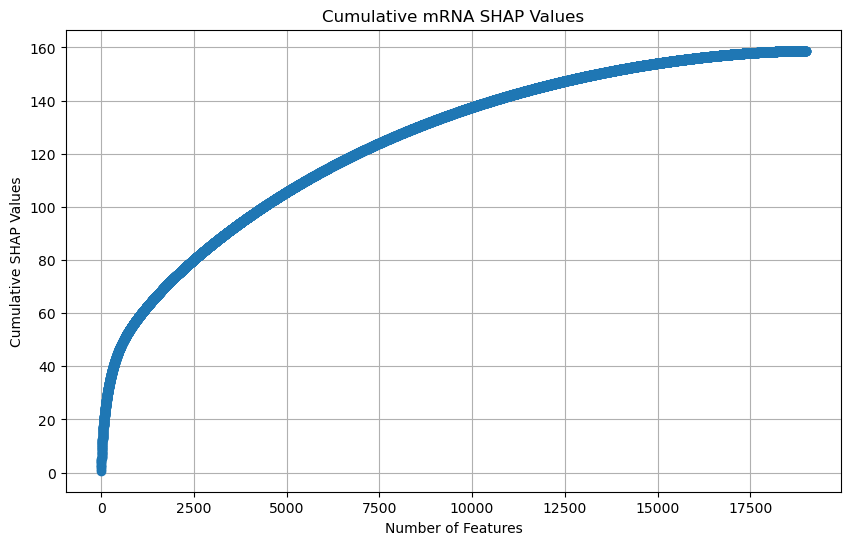

In [39]:
#Plotting cumulative SHAP values
abs_shap_values = np.abs(shap_values)
sum_shap_values = np.sum(abs_shap_values, axis=0)
sorted_sum_shap_values = np.sort(sum_shap_values)[::-1]
cumulative_sum = np.cumsum(sorted_sum_shap_values)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_sum) + 1), cumulative_sum, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative SHAP Values')
plt.title('Cumulative mRNA SHAP Values')
plt.grid(True)
plt.show()